In [3]:
import os 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import splitfolders

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Path where our data is located
base_path = "C:/Users/Dell/Downloads/archive/asl_dataset/asl_dataset/"

# Dictionary to save our 36 classes
categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df

filename  category
0      w/hand5_w_dif_seg_4_cropped.jpeg        32
1      7/hand1_7_dif_seg_1_cropped.jpeg         7
2      q/hand3_q_dif_seg_2_cropped.jpeg        26
3      3/hand1_3_bot_seg_4_cropped.jpeg         3
4      u/hand2_u_bot_seg_4_cropped.jpeg        30
...                                 ...       ...
2510   m/hand2_m_bot_seg_4_cropped.jpeg        22
2511   f/hand4_f_bot_seg_4_cropped.jpeg        15
2512  b/hand1_b_left_seg_2_cropped.jpeg        11
2513   m/hand2_m_bot_seg_3_cropped.jpeg        22
2514   2/hand1_2_top_seg_5_cropped.jpeg         2

[2515 rows x 2 columns]

In [6]:
print("number of elements = ", len(df))

number of elements =  2515


<h1>DATA EXPLORATION</h1>

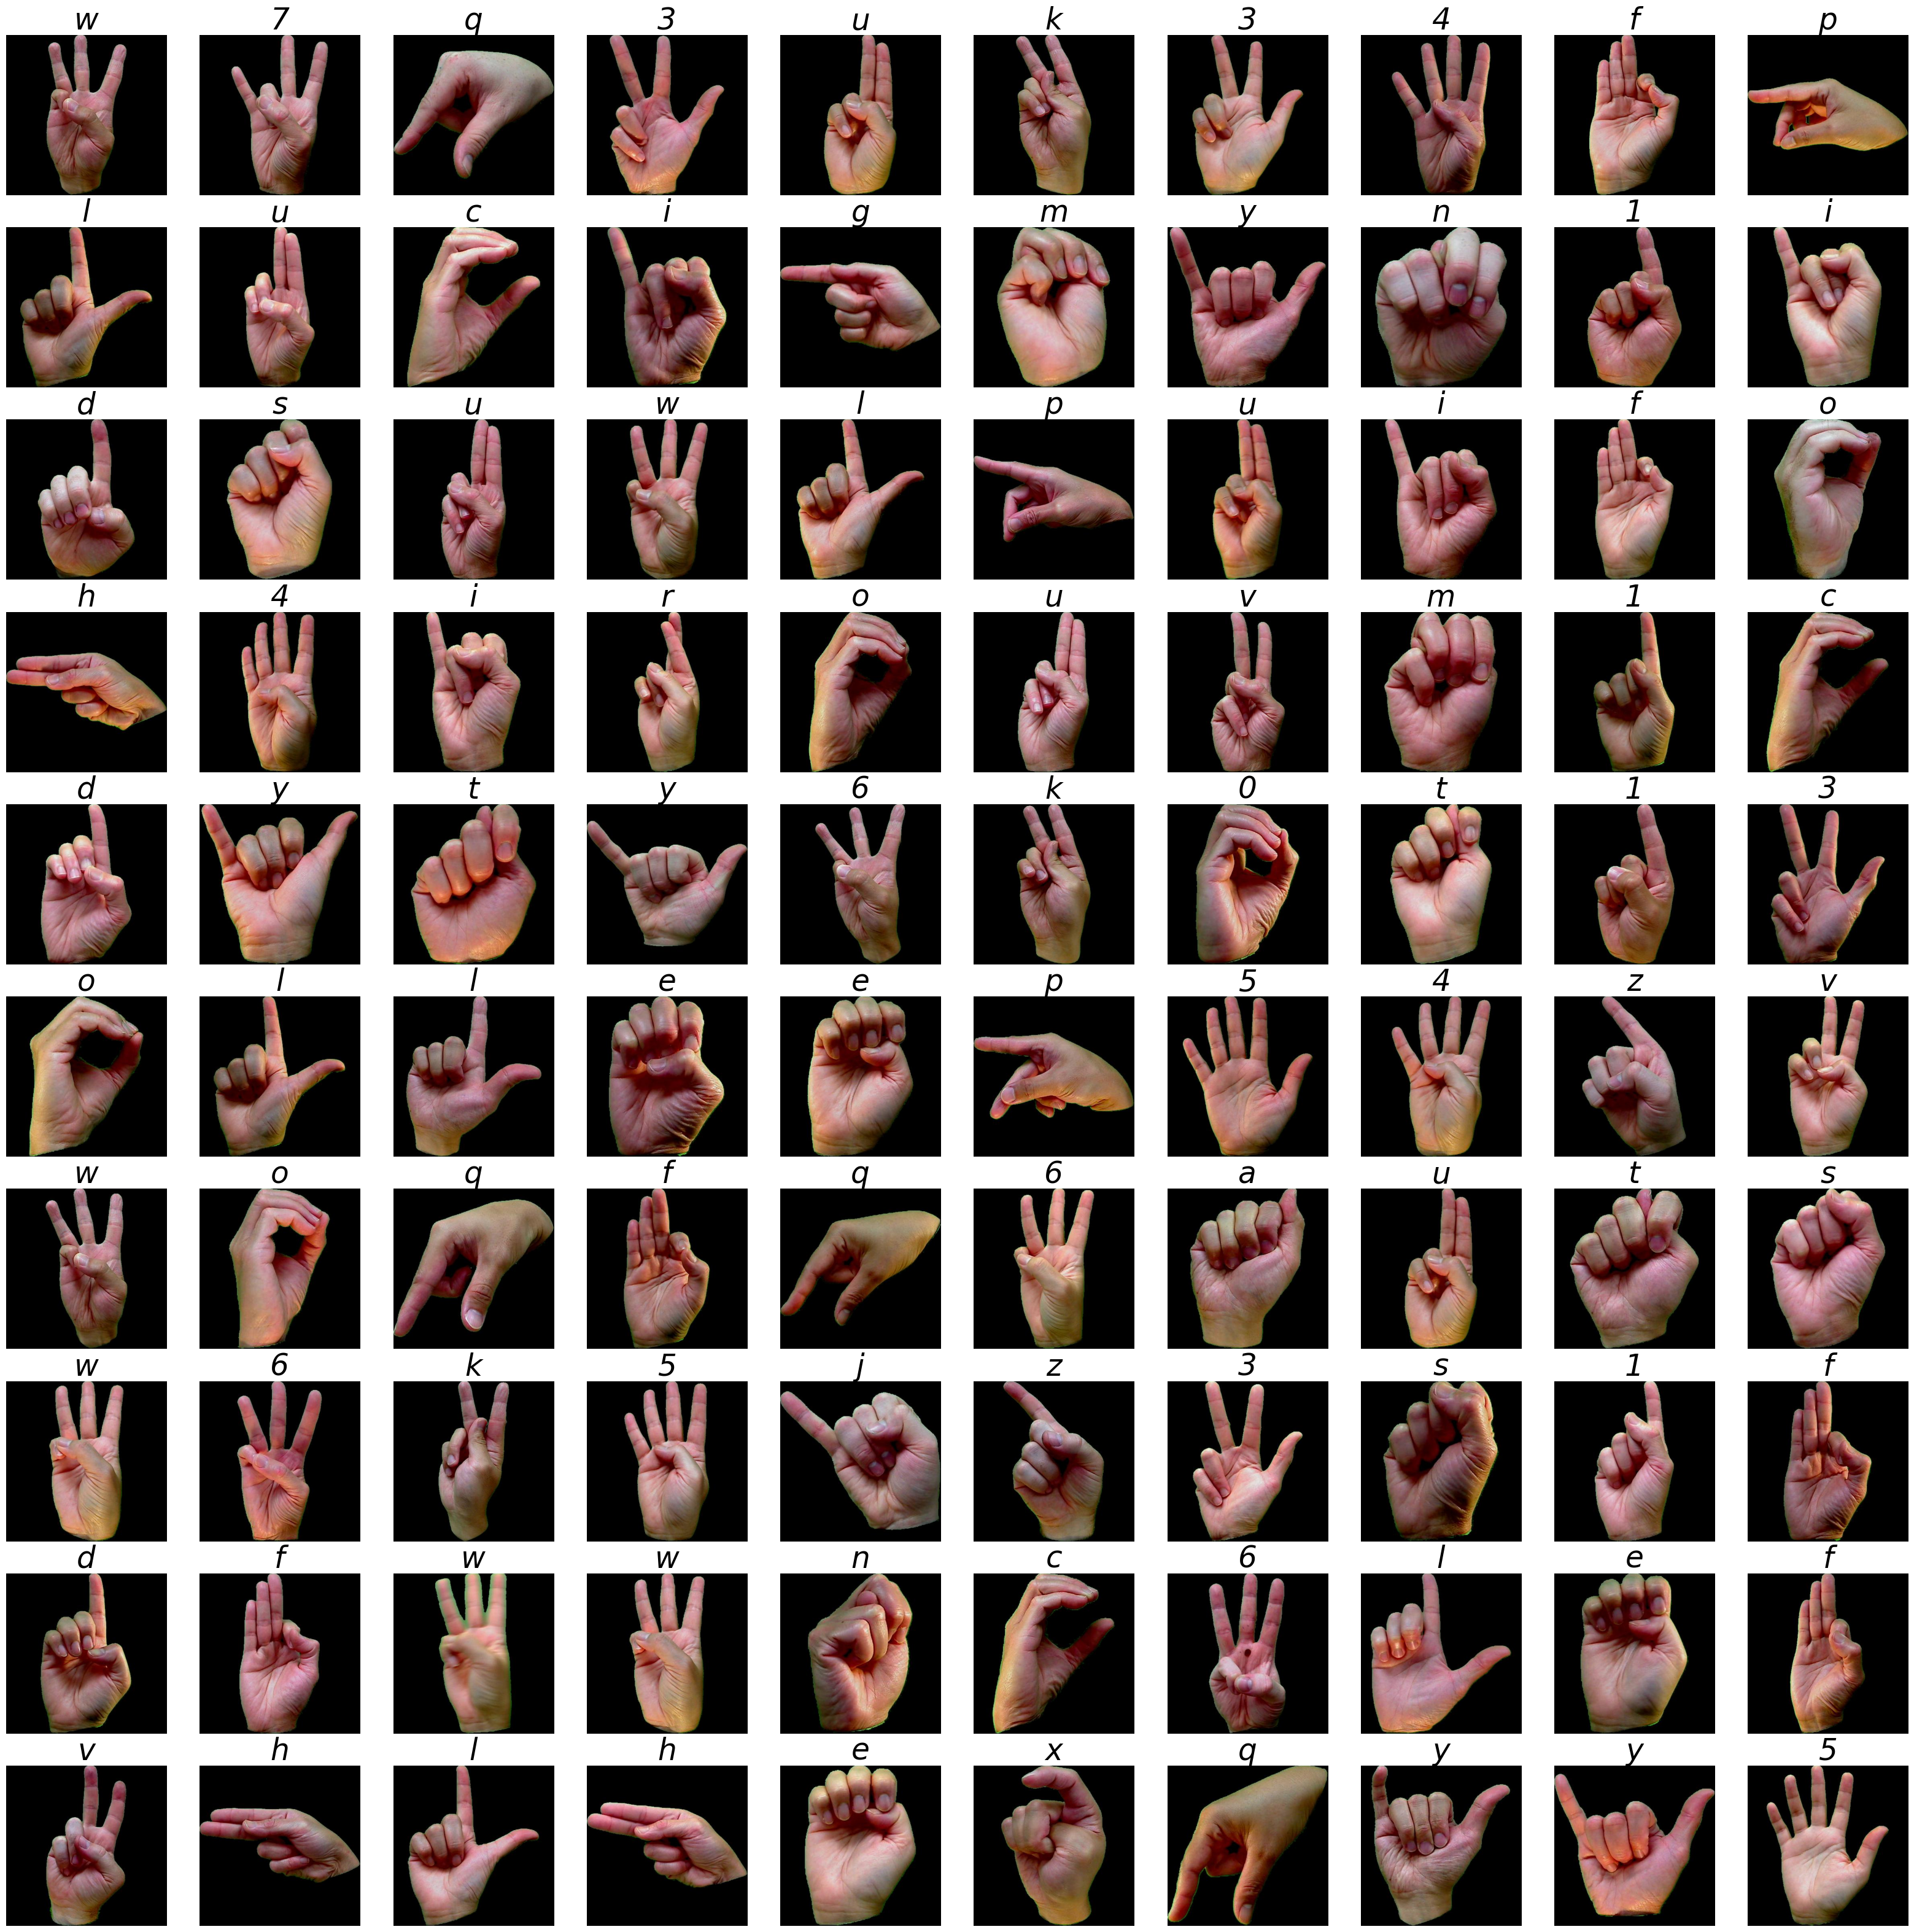

In [7]:
plt.figure(figsize=(40,40))

for i in range(100):
    path = base_path + df.filename[i]
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]],fontsize=35,fontstyle='italic')
    plt.axis("off")

In [6]:
# We will see the distrubution of data in every class.
# label,count = np.unique(df.category,return_counts=True)
# uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

# plt.figure(figsize=(14,4),dpi=200)
# sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)
# plt.show()

<h1>Train test split</h1>

In [45]:
splitfolders.ratio('C:/Users/Dell/Downloads/archive/asl_dataset/asl_dataset/',output='C:/Users/Dell/Downloads/working/', seed=1333, ratio=(0.8,0.1,0.1))

Copying files: 2515 files [00:04, 509.67 files/s]


<h1>Data preparation</h1>

In [8]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)

In [9]:
train_path = 'C:/Users/Dell/Downloads/working/train'
val_path = 'C:/Users/Dell/Downloads/working/val'
test_path = 'C:/Users/Dell/Downloads/working/test'

batch = 32
image_size = 200
img_channel = 3
n_classes = 36

In [10]:
train_data = datagen.flow_from_directory(directory= train_path, 
                                         target_size=(image_size,image_size), 
                                         batch_size = batch, 
                                         color_mode = 'grayscale',
                                         class_mode='categorical')

val_data = datagen.flow_from_directory(directory= val_path, 
                                       target_size=(image_size,image_size), 
                                       batch_size = batch,
                                       color_mode = 'grayscale', 
                                       class_mode='categorical',
                                       )

test_data = datagen.flow_from_directory(directory= test_path, 
                                         target_size=(image_size,image_size), 
                                         batch_size = batch, 
                                         color_mode = 'grayscale',
                                         class_mode='categorical',
                                         shuffle= False)

Found 2012 images belonging to 36 classes.
Found 251 images belonging to 36 classes.


Found 252 images belonging to 36 classes.


<h1>Building CNN</h1>

In [11]:
classifier = tf.keras.models.Sequential()

In [12]:

# input layer
# Block 1
classifier.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (image_size,image_size,1)))
classifier.add(Conv2D(32,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
classifier.add(MaxPooling2D(padding='same'))
classifier.add(Dropout(0.2))

# Block 2
classifier.add(Conv2D(64,3,activation='relu',padding='same'))
classifier.add(Conv2D(64,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
classifier.add(MaxPooling2D(padding='same'))
classifier.add(Dropout(0.3))

#Block 3
classifier.add(Conv2D(128,3,activation='relu',padding='same'))
classifier.add(Conv2D(128,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
classifier.add(MaxPooling2D(padding='same'))
classifier.add(Dropout(0.4))

# fully connected layer
classifier.add(Flatten())

classifier.add(Dense(512,activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(128,activation='relu'))
classifier.add(Dropout(0.3))

# output layer
classifier.add(Dense(36, activation='softmax'))




In [38]:
# early_stoping = EarlyStopping(monitor='val_loss', 
#                               min_delta=0.001,
#                               patience= 5,
#                               restore_best_weights= True, 
#                               verbose = 0)

# reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
#                                          patience = 2, 
#                                          factor=0.5 , 
#                                          verbose = 1)

In [13]:
classifier.compile(optimizer = 'adam', 
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

In [14]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      36928     
                                                        

In [15]:
classifier.fit(train_data,
                  epochs = 5,
                  validation_data = test_data)

Epoch 1/5
63/63 [==============================] - 314s 5s/step - loss: 2.6373 - accuracy: 0.2838 - val_loss: 0.9623 - val_accuracy: 0.7698
Epoch 2/5
63/63 [==============================] - 299s 5s/step - loss: 0.8162 - accuracy: 0.7644 - val_loss: 0.5059 - val_accuracy: 0.8532
Epoch 3/5
63/63 [==============================] - 289s 5s/step - loss: 0.3518 - accuracy: 0.8847 - val_loss: 0.3934 - val_accuracy: 0.8889
Epoch 4/5
63/63 [==============================] - 289s 5s/step - loss: 0.2121 - accuracy: 0.9259 - val_loss: 0.3702 - val_accuracy: 0.8810
Epoch 5/5
63/63 [==============================] - 296s 5s/step - loss: 0.1559 - accuracy: 0.9483 - val_loss: 0.3393 - val_accuracy: 0.9048


In [16]:
model_json = classifier.to_json()
with open("model_new.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')
classifier.save_weights('model_new.h5')
print('Weights saved')

Model Saved
Weights saved
